### Imports

In [1]:
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.append(os.path.dirname(os.getcwd()))
sys.path.append(os.getcwd())

import constants
from utils import print_dict
from human_eval_utils import parse_python_code, construct_test_program, code_runs_without_errors, save_results, get_erratic_problems, test_humaneval_parallel
from generic_agents.CodeInterpreterAgent import CodeInterpreterAgent

### Loading the HumanEval Dataset

In [2]:
from human_eval_utils import load_human_eval

dataset = load_human_eval()

print(len(dataset))
task = dataset[-131]
# print a random example
print(task.keys())
print(task['prompt'])
print(task['entry_point'])
# print(task['test'])

164
dict_keys(['task_id', 'prompt', 'canonical_solution', 'test', 'entry_point'])


def sort_third(l: list):
    """This function takes a list l and returns a list l' such that
    l' is identical to l in the indicies that are not divisible by three, while its values at the indicies that are divisible by three are equal
    to the values of the corresponding indicies of l, but sorted.
    >>> sort_third([1, 2, 3])
    [1, 2, 3]
    >>> sort_third([5, 6, 3, 4, 8, 9, 2])
    [2, 6, 3, 4, 8, 9, 5]
    """

sort_third


### Single Agent Coder

#### CodeInterpreterAgent

In [3]:
system_prompt = """ 
    You are an expert software engineer. You are asked to write code to solve a problem 
    which involves creating a Python method to solve a problem indicated as the comments of the method. 
    The code should be efficient and correct. The code should be written in Python. 
    Store the code solution in a file, and provide the file path as the answer.
    Do not add any assertions to the code, just complete the method. 
    Any library imports should be inside the new method, not at the top of the file.
"""

n_problems = 3
single_agent_output_dir = 'CodeGenerations/single_agent_coder'
single_agent_coder = CodeInterpreterAgent(system_prompt=system_prompt, agent_name="single_agent_coder")
print(f'Number of messages: {single_agent_coder.get_number_messages()}')


run = False
if run:
    n_correct = 0
    for n_problem in range(n_problems):
        task = dataset[-n_problem]
        
        solution_file_path = os.path.join(single_agent_output_dir, f'problem_{n_problem}.py')
        test_file_save_path = os.path.join(single_agent_output_dir, f'test_{n_problem}.py')

        response = single_agent_coder.prompt_with_output_file(task['prompt'], file_path=solution_file_path)
        code_runs = single_agent_coder.test_human_eval_solutions(solution_file_path=solution_file_path, test_code=task['test'], 
                                            method_name=task['entry_point'], test_file_save_path=test_file_save_path)
        
        print(f'Number of messages: {single_agent_coder.get_number_messages()}')
        print(f'Problem {n_problem} - Tests Passed: {code_runs}')

        if code_runs:
            n_correct += 1
        single_agent_coder.delete_all_messages()

    print(f'Correct: {n_correct}/{n_problems}')




Initializing CodeInterpreterAgent with thread id:  Thread(id='thread_zlekRZetwSEQauVSo7ayeod7', created_at=1722337282, metadata={}, object='thread', tool_resources=ToolResources(code_interpreter=None, file_search=None)) 



Number of messages: 0


#### MultiTurnLLMAgent

In [4]:
from generic_agents.MultiTurnLLMAgent import MultiTurnLLMAgent

system_prompt = """ 
    You are an expert software engineer. You are asked to write code to solve a problem 
    which involves creating a Python method to solve a problem indicated as the comments of the method. 
    You should only output the completition of the method, not the entire file.
"""

agent = MultiTurnLLMAgent(system_prompt=system_prompt)
n_tasks = len(dataset)
results = {
    "score": 0, 
    "test_counts": {"NoError": 0, "Error": 0, "AssertionError": 0, "IncorrectInput": 0}, 
    "tests_results": {}
}


run = False
if run:
    n_correct = 0
    for task_number in range(n_tasks):
        task = dataset[task_number]
        
        response = agent.user_prompt(task['prompt'])
        completion = parse_python_code(response)

        test_path = constants.HUMAN_EVAL_SINGLE_AGENT_DIR + 'test_files/' + f'problem_{task_number}.py'
        test_program = construct_test_program(task['prompt'], completion, task['test'], task['entry_point'], save_path=test_path)
        (code_works, reason) = code_runs_without_errors(file_path=test_path)
        
        print(f'Problem {task_number} - Tests Passed: {code_works}')
        if code_works:
            n_correct += 1
        if reason in results["test_counts"]:
            results["test_counts"][reason] += 1
        else:
            results["test_counts"][reason] = 1
        results["tests_results"][task_number] = (code_works, reason)

        agent.reset_messages()

    results["score"] = round(n_correct/n_tasks * 100, 4)
    save_results(results, constants.HUMAN_EVAL_SINGLE_AGENT_DIR)
    print(f'Correct: {n_correct}/{n_tasks}')
    print(results)

### LangChain AgentCoder

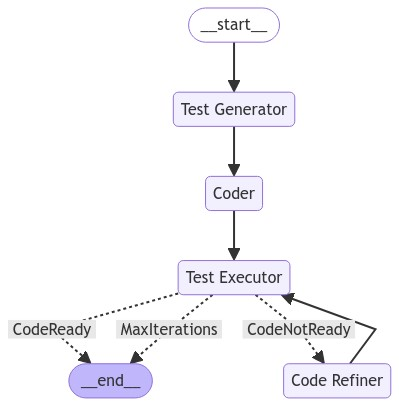

In [3]:
from multi_agent_graph import get_multi_agent_summarizer_graph
from IPython.display import Image, display

graph = get_multi_agent_summarizer_graph()
app = graph.compile()
display(Image(app.get_graph(xray=True).draw_mermaid_png())) 

def agent_coder(task_prompt, max_iterations=3, passed_tests_threshold=0.7):
    graph = get_multi_agent_summarizer_graph()
    app = graph.compile()
    
    config = {"recursion_limit": 50}
    inputs = {
        "incomplete_method": task_prompt,
        "max_iterations": max_iterations,
        "passed_tests_threshold": passed_tests_threshold,
        "current_iterations": 0,
        "feedback": '',
    }

    for event in app.stream(inputs, config=config):
        pass
        # print_dict(event)
    
    last_event_name = list(event.keys())[0]
    return event[last_event_name]['completed_method']

#### Sequential Testing

In [ ]:
n_tasks = len(dataset)
task_numbers = range(n_tasks)
# task_numbers = get_erratic_problems(file_path=constants.HUMAN_EVAL_SINGLE_AGENT_DIR)[:n_tasks]
# print(task_numbers)
passed_tests_threshold = 0.7
max_iterations = 3

results = {
    "score": 0, 
    "test_counts": {"NoError": 0, "Error": 0, "AssertionError": 0, "IncorrectInput": 0}, 
    "erratic_problems": [],
    "tests_results": {}, 
}

n_correct = 0
for task_number in task_numbers:
    task = dataset[task_number]
    
    completion = agent_coder(task['prompt'], max_iterations=max_iterations, passed_tests_threshold=passed_tests_threshold)

    test_path = constants.HUMAN_EVAL_AGENT_CODER_DIR + 'test_files/' + f'problem_{task_number}.py'
    test_program = construct_test_program(task['prompt'], completion, task['test'], task['entry_point'], save_path=test_path)
    (code_works, reason) = code_runs_without_errors(file_path=test_path)
    
    print(f'Problem {task_number} - Tests Passed: {code_works}' + f' - Reason: {reason if not code_works else ""}')
    print('\n-----------------------------------\n')
    if code_works:
        n_correct += 1
    else:
        results["erratic_problems"].append(task_number)
    if reason in results["test_counts"]:
        results["test_counts"][reason] += 1
    else:
        results["test_counts"][reason] = 1
    results["tests_results"][task_number] = (code_works, reason)

results["score"] = round(n_correct/n_tasks * 100, 4)
# save_results(results, constants.HUMAN_EVAL_AGENT_CODER_DIR)
print(f'Correct: {n_correct}/{n_tasks}')
print(results)

#### Parallel Execution

In [4]:
# Usage
n_tasks = len(dataset)
task_numbers = range(n_tasks)
# task_numbers = get_erratic_problems(file_path=constants.HUMAN_EVAL_SINGLE_AGENT_DIR)
task_numbers = task_numbers[:n_tasks] if n_tasks is not None else task_numbers
passed_tests_threshold = 0.7
max_iterations = 6

results = test_humaneval_parallel(agent_coder, task_numbers, dataset, max_iterations, passed_tests_threshold)
save_results(results, constants.HUMAN_EVAL_AGENT_CODER_DIR) 

In AgentTestGenerator
In AgentTestGenerator
In AgentTestGenerator
In AgentTestGenerator
In AgentTestGenerator
In AgentTestGenerator
In AgentTestGenerator
In AgentTestGenerator
In AgentTestGenerator
In AgentTestGenerator
In AgentTestGenerator
In AgentTestGenerator
In AgentTestGenerator
In AgentTestGenerator
In AgentTestGenerator
In AgentTestGenerator
In AgentCoder
In AgentCoder
In AgentCoder
In AgentCoder
In AgentCoder
In AgentCoder
In AgentCoder
In AgentCoder
In AgentCoder
In AgentCoder
In AgentCoder
In AgentCoder
In AgentCoder
In AgentCoder
In AgentTestExecutor, with thread id:  Thread(id='thread_qa5qWSXRvit3rwUfYwfg3L8n', created_at=1724331456, metadata={}, object='thread', tool_resources=ToolResources(code_interpreter=None, file_search=None))
In AgentTestExecutor, with thread id:  Thread(id='thread_xp8dQtSEc0YgJyAWb0ccCnwx', created_at=1724331456, metadata={}, object='thread', tool_resources=ToolResources(code_interpreter=None, file_search=None))
In AgentTestExecutor, with thread id

AttributeError: 'NoneType' object has no attribute 'content'